# Machine Learning to Remove Diffraction Spikes from Astronomical Images

## Table of contents

1. [Introduction](#Introduction)

2. [Outline of Approach: Machine Learning and Neural Networks](#Outline-of-Approach:-Machine-Learning-and-Neural-Networks)

3. [Machine Learning Approach](#Machine-Learning-with-Decision-Trees)
    - [Data Assembly](#Assemble-the-Data)
    - [Clean Data](#Clean-the-Data)
    - [Data Verification](#Check-Data-quality)
    - [Classifying with Decision Trees](#Classifying-with-Decision-Trees)
    - [Classifying with Random Forests](#Classifying-with-Random-Forests)
4. [Results](#Results)

## Introduction 


When the Hubble Space Telescope take an image of space, it does so at whatever angle the telescope is currently positioned. When the telescope returns to take a picture in a different wavelength of light, it might be at a different angle. Usually this doesn't matter-- you combine the images at different wavelengths and make pretty space pictures, ready for science. But the different angles can also cause us issues. 

### What are diffraction spikes?
Diffraction spikes beautiful, but completely artificial. When the light of the source is bright enough, like for a star, light diffracted off the support beams holding up the secondary mirror will fall onto the detector, creating spikes in the image. The picutre to the right shows this-- no matter how you hold up the secondary mirror, or how thin the support beams are, you'll get these spikes.

A Hubble Space Telescope image of stars showing numerous diffraction spikes | The theory behind it: the bars holding the secondary mirror cause bright light to scatter onto the detector
- | - 
![alt](WorkbookImages/NGC6397.jpg) | ![alt](WorkbookImages/diffraction_Spikes_all_large.jpg)

### The problem: Diffraction spikes can look like distant galaxies

A diffraction spike | A real galaxy
- | - 
![alt](WorkbookImages/ACS+IR_spike.png) | ![alt](WorkbookImages/ACS_spike.png) | ![alt](WorkbookImages/IR_spike.png) | ![alt](WorkbookImages/SEGM_spike.png) | <img src="WorkbookImages/SED_spike.png" alt="Drawing" style="width: 350px;"/>
![alt](WorkbookImages/ACS+IR_clear.png) | ![alt](WorkbookImages/ACS_clear.png) | ![alt](WorkbookImages/IR_clear.png) | ![alt](WorkbookImages/SEGM_clear.png) |<img src="WorkbookImages/SED_clear.png" alt="Drawing" style="width: 350px;"/>

Spike: 'https://relics.stsci.edu/private/abell2163/epoch2-sum/catalogs/IR_detection/PhotoZ/html/434.html'<br>
Galaxy:'https://relics.stsci.edu/private/abell1758/epoch2-sum/catalogs/IR_detection/PhotoZ/html/1942.html'

### No really...it's an issue!
It becomes even more challenging when your astronomical images observe the effects of strong gravitational lensing. The gravity from the massive galaxies in the foreground distort the light of sources behind them, causing them to appear distorted and arced. I discovered the most distant galaxy to have this kind of distortion, and you can see it's elongated shape might have been confused for a diffraction spike by a computer. 

Animation of gravitational lensing | Example of lensing field | The most distant lensed arc known
- | - 
![SegmentLocal](WorkbookImages/LensingExample.gif "segment") | <img src="WorkbookImages/FF_lensing_example.jpg" alt="Drawing" style="width: 600px;"/> | <img src="WorkbookImages/z10arcBBC.jpg" alt="Drawing" style="width: 600px;"/>


### Humans _can_ do it.. but boy is it tedious.
I created a series of webpages in an internal server and set up buttons so that I can easily cycle between samples of objects. It allowed me to classify several thousands of objects, but it was tedious work that I would prefer to not have to repeat (or have anyone repeat) on future surveys. 

## Outline of Approach: Machine Learning and Neural Networks
[[ go back to the top ]](#Table-of-contents)<br>

### Machines exist. Let's use them!
Let's try and train a computer to classify whether an object is a diffraction spike or a real galaxy. I'll try two approaches:

1. **Classic Machine Learning:** Apply decision tree and random forests to the full catalog data. It's possible that the computer can find a hidden set of relations within the catalog that will allow it to correctly determine spikes vs galaxies. 
2. **Neural Network:** Use tensorflow on the actual images themselves. This is the brute-force approach that I would take if the machine learning way fails. We will use the actual astronomical images to build a convolutional neural net capable of making the spike/galaxy judgement. 

In [1]:
from IPython.display import IFrame
IFrame("WorkbookImages/NeuralNetWorkFlow.pdf", width=1100, height=475)

## Machine Learning with Decision Trees
[[ go back to the top ]](#Table-of-contents)<br>
The rest of this notebook uses the Machine Learning approach. 

### Assemble the Data
First, I will load all the catalog data on the galaxies and spikes.

In [2]:
from sklearn.externals import joblib
import pandas as pd
tbl = joblib.load('/Users/bsalmon/Research/relics_photz/'+
                         'highztable_101617_ByScript.dump')
highz_df = tbl.to_pandas()

Below is what the actual data look like. This is the output of the full selection for distant galaxies. <p> 
**The problem is, 87% of it is junk/artifacts in the data.**

In [3]:
tbl

ID,x,y,RA,DEC,B435,eB435,V606,eV606,I814,eI814,Y105,eY105,J125,eJ125,JH140,eJH140,H160,eH160,bright_mag,bright_magerr,stel,fwhm,area,zbpz,zbpz_gt45,zbpz_l95,zbpz_u95,zez_a,zez_p,zm1,zm2,zez_l95,zez_u95,zez_gt45,zmax,cluster,epoch,url
,,,deg,deg,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,object,object,object
1023,2540.442,1366.935,172.9757935,-19.9419045,99.0,29.4956,99.0,30.1007,99.0,29.6273,27.6209,0.4096,27.5378,0.596,27.9255,0.6894,27.2978,0.3386,27.7926,28.3891,0.67,0.299,10.0,1.325,6.674,0.79,7.821,6.98,1.84,6.352,3.578,1.29,9.66,6.96,6.96,abell1300,final_processing,https://relics.stsci.edu/private/abell1300/final_processing/catalogs/IR_detection/PhotoZ/html/1023.html
1042,3023.364,1254.588,172.9672312,-19.9437767,30.4822,2.1358,29.3622,0.8521,27.3427,0.2721,26.5456,0.1677,26.7754,0.3207,26.6478,0.2532,27.0382,0.2373,26.744,28.4885,0.01,0.464,18.0,5.551,5.55,0.757,6.01,5.93,5.89,5.224,4.589,0.97,6.31,5.89,5.89,abell1300,final_processing,https://relics.stsci.edu/private/abell1300/final_processing/catalogs/IR_detection/PhotoZ/html/1042.html
176,3340.948,3066.112,172.9616033,-19.9135843,99.0,28.3486,99.0,28.9159,26.5227,0.1794,24.6562,0.0507,24.1075,0.0544,24.1204,0.0467,23.9408,0.0276,23.9691,27.9151,0.98,0.187,79.0,1.289,6.593,1.132,1.373,5.95,1.13,6.056,1.19,5.77,6.41,5.69,6.593,abell1300,final_processing,https://relics.stsci.edu/private/abell1300/final_processing/catalogs/IR_detection/PhotoZ/html/176.html
226,2099.96,2980.222,172.9836019,-19.9150163,27.7715,0.3867,30.1534,1.2754,29.0622,0.8956,25.9745,0.1103,25.5773,0.1345,25.9236,0.15,25.6212,0.0802,25.7078,28.4102,0.97,0.188,37.0,6.686,6.684,6.299,7.386,7.33,1.35,7.012,5.325,6.29,7.69,6.69,6.69,abell1300,final_processing,https://relics.stsci.edu/private/abell1300/final_processing/catalogs/IR_detection/PhotoZ/html/226.html
292,3479.579,2876.262,172.9591455,-19.9167482,99.0,28.7608,28.1261,0.3172,29.3453,1.0809,26.5863,0.1907,27.6072,0.6583,26.7672,0.311,26.7806,0.2145,26.8178,28.3777,0.0,0.725,35.0,1.354,6.374,0.497,6.368,6.59,1.39,4.797,3.381,0.28,7.27,4.51,6.374,abell1300,final_processing,https://relics.stsci.edu/private/abell1300/final_processing/catalogs/IR_detection/PhotoZ/html/292.html
295,2133.917,2872.884,172.983,-19.9168053,99.0,28.4562,30.3365,1.5617,26.8851,0.2075,26.5022,0.2044,26.992,0.4919,26.6403,0.3208,26.3106,0.1707,26.5133,28.2329,0.0,0.618,27.0,5.041,5.041,0.618,5.652,5.63,4.9,5.011,4.389,0.91,5.97,5.22,5.22,abell1300,final_processing,https://relics.stsci.edu/private/abell1300/final_processing/catalogs/IR_detection/PhotoZ/html/295.html
384,3089.851,2719.776,172.966054,-19.9193569,29.6644,1.4383,28.5407,0.503,25.795,0.0801,25.0717,0.0597,24.9926,0.0935,24.9939,0.0798,25.0509,0.0568,25.0801,27.7876,0.98,0.185,53.0,5.429,5.428,5.261,5.797,5.61,5.52,5.618,5.473,5.2,6.01,5.55,5.55,abell1300,final_processing,https://relics.stsci.edu/private/abell1300/final_processing/catalogs/IR_detection/PhotoZ/html/384.html
391,1680.349,2697.153,172.9910406,-19.9197336,28.8717,0.8019,32.6051,3.2964,28.3217,0.5332,27.1778,0.2883,27.3487,0.5379,32.6716,4.6172,26.7283,0.1994,26.9728,28.4671,0.0,0.706,29.0,1.184,5.611,0.572,6.238,6.52,1.32,4.97,3.383,0.7,7.53,5.23,5.611,abell1300,final_processing,https://relics.stsci.edu/private/abell1300/final_processing/catalogs/IR_detection/PhotoZ/html/391.html


I have many more labels I've identified, but for this project I'm just going to focus on the diffraction spikes.

In [4]:
fname="/Users/bsalmon/Research/relics_photz/stars.txt"
with open(fname) as f:
    stars=f.read().splitlines()
fname="/Users/bsalmon/Research/relics_photz/artifact_list.txt"
with open(fname) as f:
    artifacts=f.read().splitlines()
fname="/Users/bsalmon/Research/relics_photz/high-z_edge_list.txt"
with open(fname) as f:
    edge=f.read().splitlines()
fname="/Users/bsalmon/Research/relics_photz/low-z_visually.txt"
with open(fname) as f:
    lowz=f.read().splitlines()
fname="/Users/bsalmon/Research/relics_photz/low-z_irac.txt"
with open(fname) as f:
    lowz_irac=f.read().splitlines()
#fname="/Users/bsalmon/Research/relics_photz/revisit.txt"
#with open(fname) as f:
#    revisit=f.read().splitlines()
fname="/Users/bsalmon/Research/relics_photz/z9-10_notreal.txt"
with open(fname) as f:
    z910_notreal=f.read().splitlines()
fname="/Users/bsalmon/Research/relics_photz/z9-10_tier2.txt"
with open(fname) as f:
    z910_tier2=f.read().splitlines()
fname="/Users/bsalmon/Research/relics_photz/duplicates.txt"
with open(fname) as f:
    duplicates=f.read().splitlines()
fname="/Users/bsalmon/Research/relics_photz/spikes.txt"
with open(fname) as f:
    spikes=f.read().splitlines()
fname="/Users/bsalmon/Research/relics_photz/notchecked.txt"
with open(fname) as f:
    notchecked=f.read().splitlines()

### Clean the data
[[ go back to the top ]](#Table-of-contents)<br>

In [5]:
def bool_compare(thelist, tbl, **kwargs):
    bool_array = np.zeros(len(tbl), dtype=bool)
    for i in range(len(thelist)):
        if thelist[i] in tbl['url']:
            bool_array[ tbl['url'] == thelist[i] ] = True
    return bool_array

all_artifacts    = bool_compare(artifacts, tbl)
all_stars        = bool_compare(stars, tbl)
all_edge         = bool_compare(edge, tbl)
all_lowz         = bool_compare(lowz, tbl)
all_lowz_irac    = bool_compare(lowz_irac, tbl)
all_z910_notreal = bool_compare(z910_notreal, tbl)
all_z910_tier2   = bool_compare(z910_tier2, tbl)
all_duplicates   = bool_compare(duplicates, tbl)
all_spikes       = bool_compare(spikes, tbl)
all_notchecked       = bool_compare(notchecked, tbl)

all_starry = np.zeros(len(tbl), dtype=bool)
for i in range(len(tbl)):
    if (tbl[i]['stel'] >= 0.8) and (tbl[i]['Y105'] - tbl[i]['J125'] > 0.45):
        all_starry[i] = True

brightest = np.zeros(len(tbl))
clusternames_w_epochs = []
for i in range(len(tbl)):
    brightest[i] =  min(x for x in [tbl['H160'][i],
                                    tbl['JH140'][i],
                                    tbl['J125'][i],
                                    tbl['Y105'][i],99] if x >0)
    clusternames_w_epochs.append( ((tbl['url'][i]).split('/')[4]
                                   +'/'
                                   +(tbl['url'][i]).split('/')[5]) )


allclusters = list(set(clusternames_w_epochs))
allclusters.sort()

Let's take advantage of the labels you already have. Make a new column called "class" and assign everything to be "not spikes" by default.

Label things you've already classified as spikes. For now, throw out all the rest of the artifacts that you haven't yet confirmed are spikes. 

In [6]:
if len(highz_df)== len(all_spikes): # (don't do anything if you've already done this)
    highz_df['label'] = pd.Series(['not_spike']*len(highz_df), index=highz_df.index)
    highz_df.loc[all_spikes, 'label']='spike'
    highz_df = highz_df.drop(highz_df[all_notchecked].index)

In [7]:
should_be_good=highz_df[highz_df["label"].str.contains('not')]
should_be_good.url.to_csv('/Users/bsalmon/Research/relics_photz/test.csv',index=False)

In [8]:
len(should_be_good)

1641

Okay, we now have a dataset with labels. It has about 2,000 galaxies

In [9]:
import matplotlib.pyplot as plt
import seaborn as sb

Just playing around here.. let's plot a couple variables against each other and see what the data look like. 

(-100, 500)

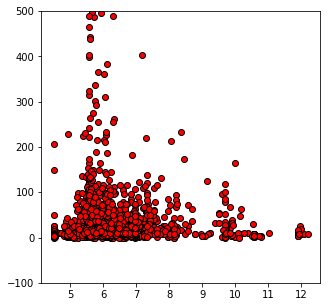

In [10]:
fig=plt.figure(figsize=[5,5])
ax=fig.add_subplot(1,1,1)
ax.plot(highz_df['zmax'],highz_df['area'], 'o', color='red', mec='k')

ax.set_ylim(-100,500)

I don't want to compare _everything_, since I know some of these paramters are completely irrelevant (like their ID number, position/coordinates on the sky). 
<p>I'm going to remove those columns from my dataframe here. 

### Check Data quality
[[ go back to the top ]](#Table-of-contents)<br>

In [11]:
clean_df = pd.DataFrame(highz_df)
clean_df = clean_df.drop(['ID', 'x', 'y', 'RA', 'DEC', 
                          #'B435', 'eB435', 'V606', 'eV606', 'I814',
                          #'eI814', 'Y105', 'eY105', 'J125', 'eJ125', 
                          #'JH140', 'eJH140', 'bright_mag', 
                          'zbpz','zbpz_gt45', 'zbpz_l95', 'zbpz_u95', 
                          'zez_a', 'zez_p', 'zm1', 'zm2','zez_l95', 
                          'zez_u95', 'zez_gt45', 'cluster', 'epoch', 'url'], axis=1)
clean_df = clean_df.drop(clean_df[clean_df['H160']>90].index)
clean_df = clean_df.drop(clean_df[clean_df['eH160']<=0].index)

Now let's look at trends in a broader way with corner plots.

/Users/bsalmon/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


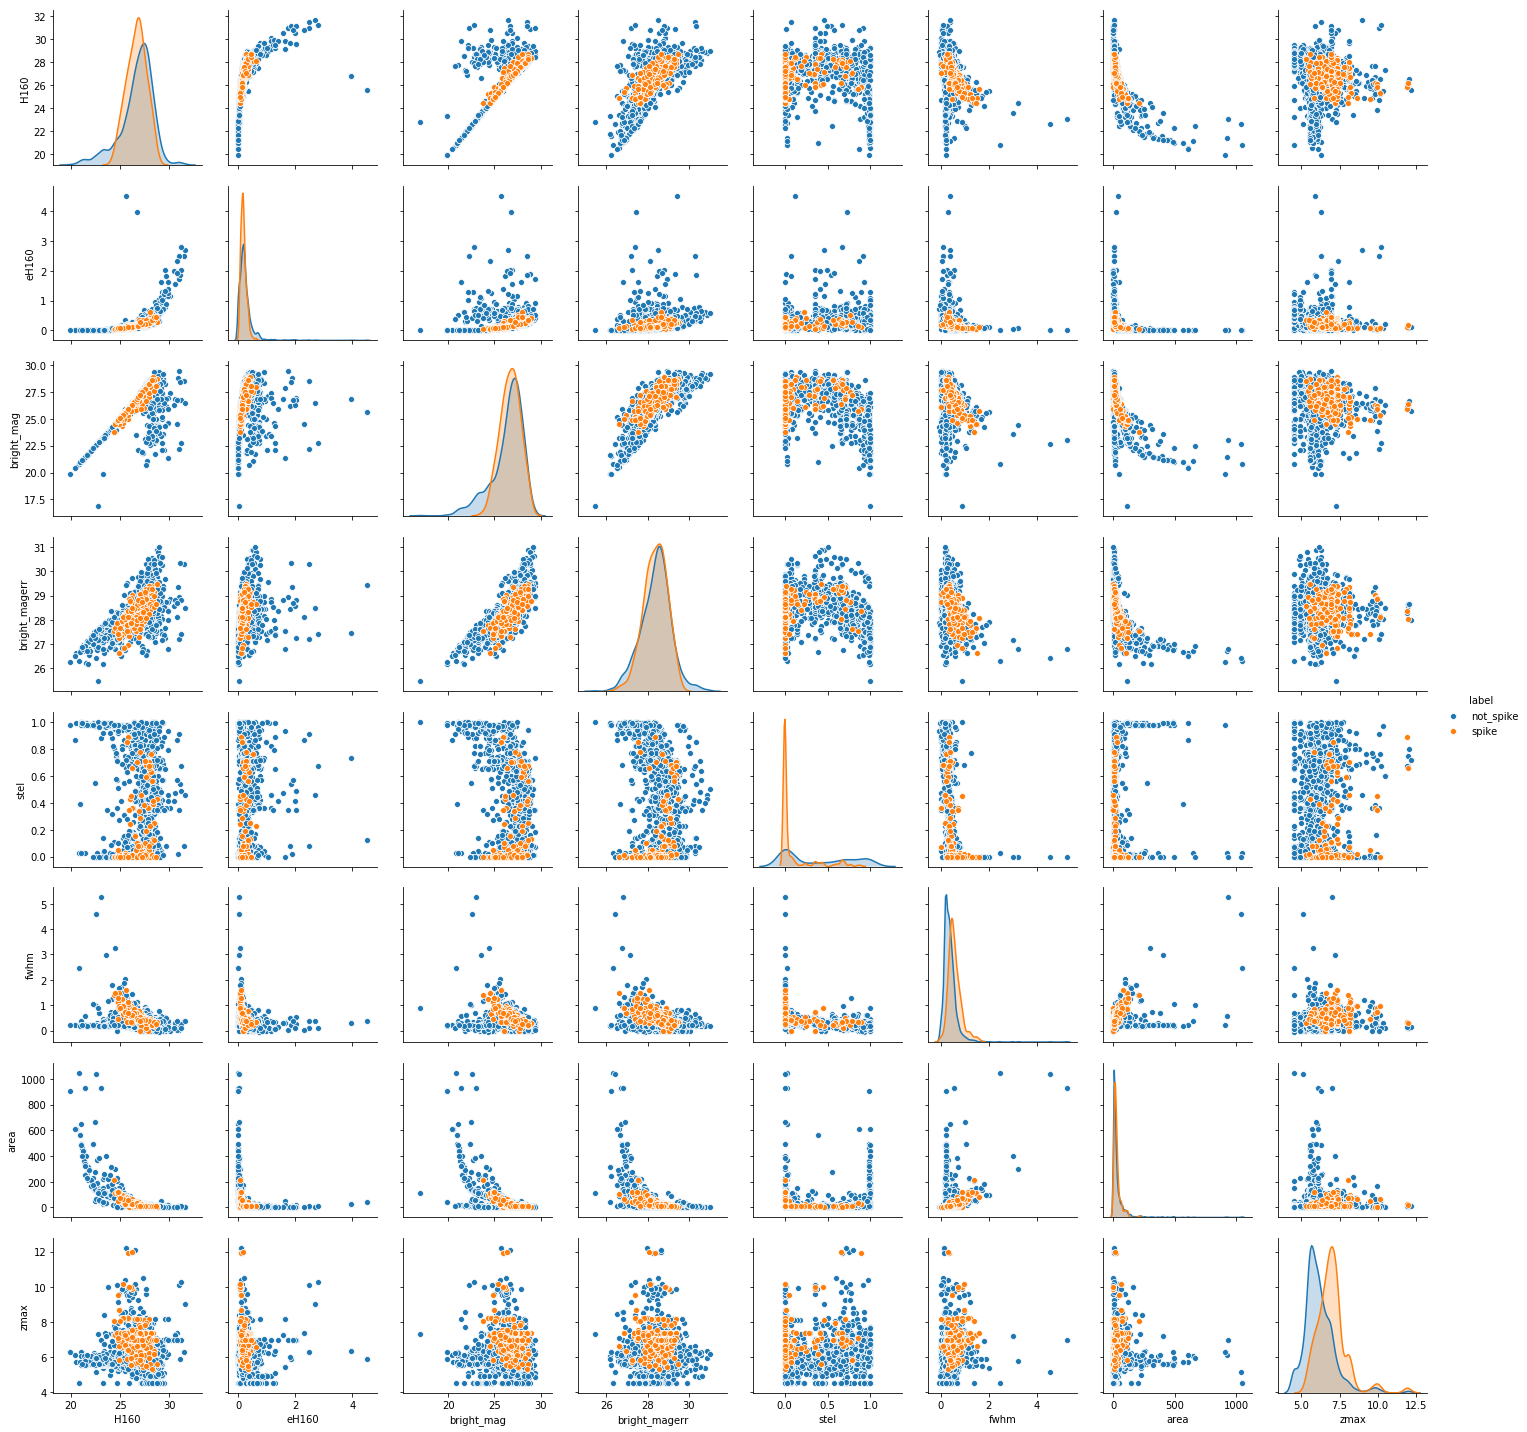

In [12]:
sb.pairplot(clean_df.drop(['B435', 'eB435', 'V606', 'eV606', 
                           'I814', 'eI814', 'Y105', 'eY105', 
                           'J125', 'eJ125', 'JH140', 'eJH140'], axis=1), hue='label')

In [13]:
# Save sample to file
clean_df.to_csv('/Users/bsalmon/BrettSalmon/data_science/'+
                'spike_data_clean.csv', index=False)

In [14]:
# We can extract the data in this format from pandas like this:
all_inputs = clean_df[['B435', 'eB435', 'V606', 'eV606', 
                       'I814', 'eI814', 'Y105', 'eY105',
                       'J125', 'eJ125', 'JH140', 'eJH140', 
                       'H160', 'eH160', 'bright_mag',
                       'bright_magerr', 'stel', 'fwhm', 'area', 'zmax']].values

# Similarly, we can extract the class labels
all_labels = clean_df['label'].values

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the class in all_labels[5]

# Here's what a subset of our inputs looks like:
all_inputs[:3]

array([[9.90000000e+01, 2.94956000e+01, 9.90000000e+01, 3.01007000e+01,
        9.90000000e+01, 2.96273000e+01, 2.76209000e+01, 4.09600000e-01,
        2.75378000e+01, 5.96000000e-01, 2.79255000e+01, 6.89400000e-01,
        2.72978000e+01, 3.38600000e-01, 2.77926000e+01, 2.83891000e+01,
        6.70000017e-01, 2.99000000e-01, 1.00000000e+01, 6.96000004e+00],
       [3.04822000e+01, 2.13580000e+00, 2.93622000e+01, 8.52100000e-01,
        2.73427000e+01, 2.72100000e-01, 2.65456000e+01, 1.67700000e-01,
        2.67754000e+01, 3.20700000e-01, 2.66478000e+01, 2.53200000e-01,
        2.70382000e+01, 2.37300000e-01, 2.67440000e+01, 2.84885000e+01,
        9.99999978e-03, 4.64000000e-01, 1.80000000e+01, 5.88999987e+00],
       [9.90000000e+01, 2.83486000e+01, 9.90000000e+01, 2.89159000e+01,
        2.65227000e+01, 1.79400000e-01, 2.46562000e+01, 5.07000000e-02,
        2.41075000e+01, 5.44000000e-02, 2.41204000e+01, 4.67000000e-02,
        2.39408000e+01, 2.76000000e-02, 2.39691000e+01, 2.7915

Okay now we've got reliable data.. let's split it into a training and test sample. <p>
Here I  do a simple random split of 25% of the total sample to be the test sample.

### Classifying with Decision Trees
[[ go back to the top ]](#Table-of-contents)<br>

In [15]:
from sklearn.model_selection import train_test_split
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

Now let's set up a Decision Tree to classify the training sample. I'll use one from ```sklearn```. <br>
The score tells us how accurate the training set was, with unity being perfect classification. 

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.8496420047732697

Hmm 85% seems good but not great. Let's see how well it does over 1,000 cuts of the test/train samples.

''

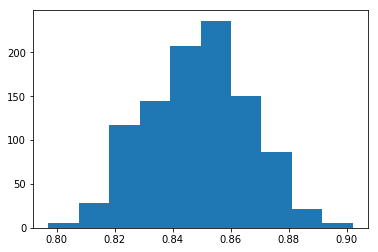

In [17]:
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)
;

Most of the time, the model hits ~85%, but it's worrisome that it never gets better than 90%. It's probably overfitting, and not doing well at classifying new data. This could mean that it's straight up a big pile of donkey dookie. <p>
Let's try splitting our testing and training sets with K-fold cross-validation. It split the data into ```k``` subsets, say 10, then uses one subset as the testing set, and the rest as training. You repeat until each ```k``` set has had a turn to be the testing set.

''

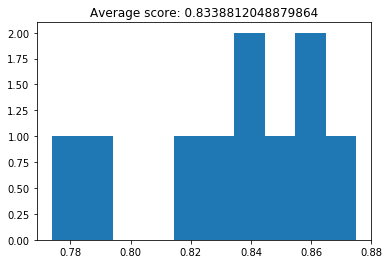

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

The average score still looks low. The decision trees make a lot of.. well.. decisions, and we can guide those decisions with a number of parameters. For example, we can fool with the criterion like Gini vs entropy. They are both very similar, but other parameters could make a difference. This will tell us which parameters are the best to vary.

In [26]:
from sklearn.model_selection import GridSearchCV
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8959952181709504
Best parameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'splitter': 'best'}


Use this grid search to set the best decision tree classifier

In [27]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=1, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
## This use Graphviz to visualize the model's performance.. 
## This plot didn't seem to work, so I'm skipping for now.
import sklearn.tree as tree
from sklearn.externals.six import StringIO

with open('iris_dtc.png', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

<img src="iris_dtc.png" />

### Classifying with Random Forests
[[ go back to the top ]](#Table-of-contents)<br>

Random forests are like a set of decision trees (duh). Each "tree" is trained on a random subset of data, and trees work togethe to make the best classifier.

In [34]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.8983861326957562
Best parameters: {'criterion': 'gini', 'n_estimators': 100, 'max_features': 4}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Results
[[ go back to the top ]](#Table-of-contents)<br>
Let's put everying into one final string and see how well the classifier does!

-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	spike	(Actual: spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	not_spike	(Actual: not_spike)
-->	spike	(Actual: spike)


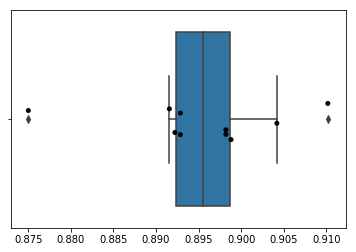

In [100]:
%matplotlib inline
import pandas as pd
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# We can jump directly to working with the clean data because we saved our cleaned data set
clean_df = pd.read_csv('/Users/bsalmon/BrettSalmon/data_science/'+
                       'spike_data_clean.csv')


# We can extract the data in this format from pandas like this:
all_inputs = clean_df[['B435', 'eB435', 'V606', 'eV606', 
                       'I814', 'eI814', 'Y105', 'eY105',
                       'J125', 'eJ125', 'JH140', 'eJH140', 
                       'H160', 'eH160', 'bright_mag',
                       'bright_magerr', 'stel', 'fwhm', 'area', 'zmax']].values

# Similarly, we can extract the class labels
all_labels = clean_df['label'].values

# This is the classifier that came out of Grid Search
random_forest_classifier = RandomForestClassifier(criterion='gini', 
                                                  max_features=4, 
                                                  n_estimators=100)

# All that's left to do now is plot the cross-validation scores
rf_classifier_scores = cross_val_score(random_forest_classifier, 
                                       all_inputs, all_labels, cv=10)
sb.boxplot(rf_classifier_scores)
sb.stripplot(rf_classifier_scores, jitter=True, color='black')

# ...and show some of the predictions from the classifier
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)

random_forest_classifier.fit(training_inputs, training_classes)

#for input_features, prediction, actual in zip(#testing_inputs[:10],
for prediction, actual in zip(random_forest_classifier.predict(testing_inputs[0:30]),
                              testing_classes[0:20]):
#        print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))
    print('-->\t{}\t(Actual: {})'.format(prediction, actual))

So it clearly works _some_ of the time.. but my guess is that that my sample has too few labeled spikes compared to non-spikes (galaxies). If I wanted to hammer the machine learning approach, I would focus my efforts on improving the dataset: include more of my classified objects, and maybe even classify more objects outside of high-z galaxies, to help decision trees pick out the actual spikes. <p>

However, since I'm doing this for fun (err.. for free), I want to explore other methods. In the next notebook, I will try neural networks to classify the image directly. 